In [1]:
import ast
import glob
import warnings
from collections import defaultdict
from datetime import date

import numpy as np
import pandas as pd
import wandb
import matplotlib.pyplot as plt

today = date.today()
api = wandb.Api()

# # Find all csv files in the current directory
csv_files = glob.glob("csv/*.csv")
# # Collect all the names of the csv files without the extension
csv_names = [csv_file[:-4] for csv_file in csv_files]
project_name = "curvature_july_10th_noresconnection"  
user = "telyatnikov_sap"

if project_name not in csv_names:
    runs = api.runs(f"{user}/{project_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items() if not k.startswith("_")}
        )

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list}
    )

    runs_df.to_csv(f"csv/{user}_{project_name}.csv")
else:
    runs_df = pd.read_csv(f"csv/{user}_{project_name}.csv", index_col=0)

    for row in runs_df.iloc:
        row["summary"] = ast.literal_eval(row["summary"])
        row["config"] = ast.literal_eval(row["config"])


for row in runs_df.iloc:
    row["summary"].update(row["config"])

lst = [i["summary"] for i in runs_df.iloc]
df = pd.DataFrame.from_dict(lst)

df_init = df.copy()


In [2]:
def normalize_column(df, column_to_normalize):
    # Use json_normalize to flatten the nested dictionaries into separate columns
    flattened_df = pd.json_normalize(df[column_to_normalize])
    # Rename columns to include 'nested_column' prefix
    flattened_df.columns = [
        f"{column_to_normalize}.{col}" for col in flattened_df.columns
    ]
    # Concatenate the flattened DataFrame with the original DataFrame
    result_df = pd.concat([df, flattened_df], axis=1)
    # Get new columns names
    new_columns = flattened_df.columns
    # Drop the original nested column if needed
    result_df.drop(column_to_normalize, axis=1, inplace=True)
    return result_df, new_columns


# Config columns to normalize
columns_to_normalize = ["model", "dataset", "callbacks", "paths", "transforms"]

# Keep track of config columns added
config_columns = []
for column in columns_to_normalize:
    df, columns = normalize_column(df, column)
    config_columns.extend(columns)

In [3]:
print(df['dataset.loader.parameters.data_name'].unique())
print("Num unique datasets:", len(df['dataset.loader.parameters.data_name'].unique()))

[nan 'Cora' 'citeseer' 'PubMed' 'roman_empire' 'minesweeper' 'Wisconsin'
 'US-county-demos']
Num unique datasets: 8


In [4]:
[i for i in df.columns if "dataset" in i]

['dataset.loader._target_',
 'dataset.loader.parameters.data_dir',
 'dataset.loader.parameters.data_name',
 'dataset.loader.parameters.data_type',
 'dataset.loader.parameters.data_domain',
 'dataset.parameters.task',
 'dataset.parameters.loss_type',
 'dataset.parameters.task_level',
 'dataset.parameters.num_classes',
 'dataset.parameters.num_features',
 'dataset.parameters.monitor_metric',
 'dataset.split_params.k',
 'dataset.split_params.data_seed',
 'dataset.split_params.split_type',
 'dataset.split_params.train_prop',
 'dataset.split_params.data_split_dir',
 'dataset.split_params.learning_setting',
 'dataset.dataloader_params.batch_size',
 'dataset.dataloader_params.pin_memory',
 'dataset.dataloader_params.num_workers',
 'dataset.loader.parameters.year',
 'dataset.loader.parameters.task_variable',
 'dataset.split_params.standardize']

In [5]:
df['transforms.R.loops'].fillna('No Rewiring', inplace=True)
df['transforms.R.lower_bound_eq'].fillna('No Rewiring', inplace=True)
df['transforms.R.compute_every_it'].fillna('No Rewiring', inplace=True)



/tmp/ipykernel_209928/3288209616.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['transforms.R.loops'].fillna('No Rewiring', inplace=True)
/tmp/ipykernel_209928/3288209616.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No Rewiring' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['transforms.R.loops'].fillna('No Rewiring', inplace=True)
/tmp/ipykernel_209928/3288209616.py:2: FutureWarning:

In [6]:
df.loc[df['dataset.loader.parameters.data_name'] == 'US-county-demos', 'dataset.loader.parameters.data_name'] = df.loc[df['dataset.loader.parameters.data_name'] == 'US-county-demos', 'dataset.loader.parameters.data_name'] + '-' + df.loc[df['dataset.loader.parameters.data_name'] == 'US-county-demos', 'dataset.loader.parameters.task_variable']

### Get grouped df

In [7]:
df.shape


(758, 138)

In [8]:
# drop na where 'dataset.loader.parameters.data_name' is na
df = df.dropna(subset=['dataset.loader.parameters.data_name'])

In [9]:
df.shape

(757, 138)

In [10]:
# Extract best results for each model and dataset
# 1. Keep the columns that are necessary for the comparison
sweeped_columns = [
    'transforms.R.loops', 
    'transforms.R.lower_bound_eq',
    'model.backbone.num_layers',
    'transforms.R.compute_every_it',
]
run_columns = ['dataset.split_params.data_seed','seed',]

# Dataset and model columns
dataset_model_columns = ['model.model_name', 'dataset.loader.parameters.data_name']

# Performance columns
performance_columns = [
    'val/loss', 'test/loss',
    'val/mae', 'test/mae',
    'val/mse', 'test/mse',
    'val/accuracy', 'test/accuracy',
    'val/auroc','test/auroc',
    'val/recall', 'test/recall',
    'val/precision', 'test/precision',
    ]
keep_columns = dataset_model_columns + sweeped_columns + performance_columns + run_columns
df = df[keep_columns]

In [11]:
performance_classification = [
    'val/accuracy', 'test/accuracy',
    'val/auroc','test/auroc',
    'val/recall', 'test/recall',
    'val/precision', 'test/precision',
    ]
performance_regression = [
    'val/mae', 'test/mae',
    'val/mse', 'test/mse',
    ]
# Define a dict of dicts for each dataset the corresponding optimization metrics
optimization_metrics = {
    'IMDB-MULTI': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'IMDB-BINARY': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'REDDIT-BINARY': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'NCI109': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'NCI1': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'PROTEINS': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'MUTAG': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'Cora': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'citeseer': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'PubMed': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},

    'roman_empire': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    'amazon_ratings': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},
    
    'Wisconsin': {'optim_metric': 'val/accuracy', 'eval_metric': 'test/accuracy', 'direction': 'max', 'performance_columns': performance_classification},

    
    'tolokers': {'optim_metric': 'val/auroc', 'eval_metric': 'test/auroc', 'direction': 'max', 'performance_columns': performance_classification},
    'questions': {'optim_metric': 'val/auroc', 'eval_metric': 'test/auroc', 'direction': 'max', 'performance_columns': performance_classification},
    'minesweeper': {'optim_metric': 'val/auroc', 'eval_metric': 'test/auroc', 'direction': 'max', 'performance_columns': performance_classification},

    'ZINC': {'optim_metric': 'val/mae', 'eval_metric': 'test/mae', 'direction': 'min', 'performance_columns': performance_regression},
    
    'US-county-demos-UnemploymentRate': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},
    'US-county-demos-BachelorRate': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},
    'US-county-demos-DeathRate': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},
    'US-county-demos-BirthRate': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},
    'US-county-demos-MigraRate': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},
    'US-county-demos-MedianIncome': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},
    'US-county-demos-Election': {'optim_metric': 'val/mse', 'eval_metric': 'test/mse', 'direction': 'min', 'performance_columns': performance_regression},

} 

len(optimization_metrics)

24

In [12]:
performance_classification = [
    'val/accuracy', 'test/accuracy',
    'val/auroc','test/auroc',
    'val/recall', 'test/recall',
    'val/precision', 'test/precision',
    ]
performance_regression = [
    'val/mae', 'test/mae',
    'val/mse', 'test/mse',
    ]

search_metric_types = ['accuracy',] #'auroc', 'recall', 'precision']


for search_metric_type in search_metric_types:

    # Get unique datasets
    datasets = list(df['dataset.loader.parameters.data_name'].unique())
    # Get unique models
    models = list(df['model.model_name'].unique())

    best_results = defaultdict(dict)
    best_results_all_metrics = defaultdict(dict)
    best_runs = defaultdict(dict)
    collect_subsets = defaultdict(dict)
    collect_bast_parameters = defaultdict(dict)
    # Got over each dataset and model and find the best result
    for dataset in datasets:
        for model in models:
            # Get the subset of the DataFrame for the current dataset and model
            subset = df[
                (df['dataset.loader.parameters.data_name'] == dataset)
                & (df['model.model_name'] == model)
            ]

            optim_metric = optimization_metrics[dataset]['optim_metric']
            eval_metric = optimization_metrics[dataset]['eval_metric']
            direction = optimization_metrics[dataset]['direction']
            
            # Keep metrics that matters for dataset
            performance_columns = optimization_metrics[dataset]['performance_columns']
            subset = subset[dataset_model_columns + sweeped_columns + performance_columns + run_columns]

            aggregated = subset.groupby(sweeped_columns, dropna=False).agg(
                {col: ["mean", "std"] for col in performance_columns},
            )

            # Go from MultiIndex to Index
            aggregated = aggregated.reset_index()
            aggregated = aggregated.sort_values(
                    by=(optim_metric, "mean"), ascending=(direction == 'min')
                )
            
            # Git percent in case of classification
            if 'test/accuracy' in performance_columns:
                # Go over all the performance columns and multiply by 100
                for col in performance_columns:
                    aggregated[(col, "mean")] *= 100
                    aggregated[(col, "std")] *= 100
                
                # Round performance columns values up to 2 decimal points
                for col in performance_columns:
                    aggregated[(col, "mean")] = aggregated[(col, "mean")].round(2)
                    aggregated[(col, "std")] = aggregated[(col, "std")].round(2)
                
                
            else:
                # Round all values up to 4 decimal points
                # Round performance columns values up to 4 decimal points
                for col in performance_columns:
                    aggregated[(col, "mean")] = aggregated[(col, "mean")].round(2)
                    aggregated[(col, "std")] = aggregated[(col, "std")].round(2)
            
            
            collect_subsets[dataset] = aggregated.copy()
    
    

sweeped_columns = [
    'transforms.R.loops', 
    'transforms.R.lower_bound_eq',
    'model.backbone.num_layers',
    'transforms.R.compute_every_it',
]

# Delete 'US-county-demos-Election' from datasets
datasets.remove('US-county-demos-Election')

for dataset in datasets:
    aggregated = collect_subsets[dataset]
    # For every model.backbone.num_layers get make a bar plot for each sweeped column
    for num_layers in aggregated['model.backbone.num_layers'].unique():
        agg_subset = aggregated[aggregated['model.backbone.num_layers']==num_layers]

        cols = ['transforms.R.loops', 'transforms.R.lower_bound_eq', 'model.backbone.num_layers', 'transforms.R.compute_every_it']

        # iterate over rows
        model_names = []
        for index, row in agg_subset.iterrows():
            # Get values of the row
            values = [row[col].item() for col in cols]
            # Count "No Rewiring" values
            no_rewiring = values.count("No Rewiring")
            
            if no_rewiring == 3:
                model_name = f"base_model|Layers={row['model.backbone.num_layers'].item()}"
            else:
                model_name = ''
                for col, value in zip(cols, values):
                    if col == 'transforms.R.loops':
                        model_name += f"RLo={value}|"
                    elif col == 'transforms.R.lower_bound_eq':
                        model_name += f"LBa={value}|"
                    elif col == 'model.backbone.num_layers':
                        pass
                        #model_name += f"NLa={value}|"
                    elif col == 'transforms.R.compute_every_it':
                        model_name += f"RIt={value}|"
                    else:
                        raise ValueError("Unknown column")
            model_names.append(model_name)
        agg_subset['Model_name'] = model_names
        
        # Plotting
        plt.figure(figsize=(12, 6))
        agg_subset.sort_values(by=('test/accuracy','mean'), ascending=False, inplace=True)
        model_names = agg_subset['Model_name']
        
        accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
        accuracy_stds = np.array(agg_subset[('test/accuracy','std')])
        bars = plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=5, color='skyblue')

        accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
        # Adding data labels on top of bars
        for bar, mean in zip(bars, accuracy_means):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean:.1f}', ha='center', va='bottom')
        #plt.xticks(rotation=45)
        plt.title(f"Model performance for {dataset} dataset")
        plt.ylabel("Test accuracy")
        plt.tight_layout()
        delta = np.array(agg_subset[('test/accuracy','std')]).max() + 1
        plt.ylim((agg_subset[('test/accuracy','mean')].min()-delta).round(), (agg_subset[('test/accuracy','mean')].max()+delta).round())
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        # Rotate x-axis labels
        plt.xticks(rotation=45, ha="right", fontsize=8)

        num_layers = agg_subset[agg_subset['Model_name'].apply(lambda x:  True if 'base_model' in x  else False)]['Model_name'].item().split('|')[1]
        plt.savefig(f"figures/model_performance_{dataset}_num_layers={num_layers}.png",dpi=300, bbox_inches = "tight")
        plt.close()

/tmp/ipykernel_209928/4137887158.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_subset['Model_name'] = model_names
/tmp/ipykernel_209928/4137887158.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_subset.sort_values(by=('test/accuracy','mean'), ascending=False, inplace=True)
/tmp/ipykernel_209928/4137887158.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [13]:
import os 
image_paths = sorted(glob.glob(f'figures/*.png'))
# Load and stuck toghether into one pdf
from PIL import Image

def load_images(image_paths):
    """Load images from given paths and convert to RGB."""
    images = []
    for path in image_paths:
        img = Image.open(path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        images.append(img)
    return images

image_paths = [img_path for img_path in image_paths]

sorted(image_paths)

a = [(path, "_".join([path.split('_')[2], path.split('=')[-1].split('.')[-2]])) for path in image_paths]
# Sort by  second arg of tuple
a = sorted(a, key=lambda x: x[1])

image_paths = [x[0] for x in a]

images = load_images(image_paths)


# Save into the pdf with current date as name
output_pdf_path = f'figures/exp_date={today}.pdf'


if images:
    images[0].save(output_pdf_path, save_all=True, append_images=images[1:], quality=95)

print(f'Images have been saved to {output_pdf_path}')

# Delete image_paths
for img_path in image_paths:
    os.remove(img_path)
    print(f'{img_path} has been removed')

Images have been saved to figures/exp_date=2024-07-11.pdf
figures/model_performance_Cora_num_layers=Layers=10.0.png has been removed
figures/model_performance_Cora_num_layers=Layers=6.0.png has been removed
figures/model_performance_Cora_num_layers=Layers=8.0.png has been removed
figures/model_performance_Cora_num_layers=Layers=10.png has been removed
figures/model_performance_PubMed_num_layers=Layers=10.0.png has been removed
figures/model_performance_PubMed_num_layers=Layers=6.0.png has been removed
figures/model_performance_PubMed_num_layers=Layers=8.0.png has been removed
figures/model_performance_Wisconsin_num_layers=Layers=10.0.png has been removed
figures/model_performance_Wisconsin_num_layers=Layers=6.0.png has been removed
figures/model_performance_Wisconsin_num_layers=Layers=8.0.png has been removed
figures/model_performance_citeseer_num_layers=Layers=10.0.png has been removed
figures/model_performance_citeseer_num_layers=Layers=6.0.png has been removed
figures/model_performa

In [23]:
image_paths

[]

'Cora'

In [25]:
image_paths

['figures/model_performance_Cora_num_layers=Layers=6.png',
 'figures/model_performance_PubMed_num_layers=Layers=6.png',
 'figures/model_performance_Wisconsin_num_layers=Layers=6.png',
 'figures/model_performance_citeseer_num_layers=Layers=6.png',
 'figures/model_performance_minesweeper_num_layers=Layers=6.png',
 'figures/model_performance_roman_empire_num_layers=Layers=6.png',
 'figures/model_performance_Cora_num_layers=Layers=8.png',
 'figures/model_performance_PubMed_num_layers=Layers=8.png',
 'figures/model_performance_Wisconsin_num_layers=Layers=8.png',
 'figures/model_performance_citeseer_num_layers=Layers=8.png',
 'figures/model_performance_minesweeper_num_layers=Layers=8.png',
 'figures/model_performance_roman_empire_num_layers=Layers=8.png',
 'figures/model_performance_Cora_num_layers=Layers=10.png',
 'figures/model_performance_PubMed_num_layers=Layers=10.png',
 'figures/model_performance_Wisconsin_num_layers=Layers=10.png',
 'figures/model_performance_citeseer_num_layers=Layer

In [16]:



sweeped_columns = [
    'transforms.R.loops', 
    'transforms.R.lower_bound_eq',
    'model.backbone.num_layers',
    'transforms.R.compute_every_it',
]

# For every model.backbone.num_layers get make a bar plot for each sweeped column
for num_layers in aggregated['model.backbone.num_layers'].unique():
    agg_subset = aggregated[aggregated['model.backbone.num_layers']==num_layers]

    cols = ['transforms.R.loops', 'transforms.R.lower_bound_eq', 'model.backbone.num_layers', 'transforms.R.compute_every_it']

    # iterate over rows
    model_names = []
    for index, row in agg_subset.iterrows():
        # Get values of the row
        values = [row[col].item() for col in cols]
        # Count "No Rewiring" values
        no_rewiring = values.count("No Rewiring")
        
        if no_rewiring == 3:
            model_name = f"base_model|Layers={row['model.backbone.num_layers'].item()}"
        else:
            model_name = ''
            for col, value in zip(cols, values):
                if col == 'transforms.R.loops':
                    model_name += f"RLo={value}|"
                elif col == 'transforms.R.lower_bound_eq':
                    model_name += f"LBa={value}|"
                elif col == 'model.backbone.num_layers':
                    pass
                    #model_name += f"NLa={value}|"
                elif col == 'transforms.R.compute_every_it':
                    model_name += f"RIt={value}|"
                else:
                    raise ValueError("Unknown column")
        model_names.append(model_name)
    agg_subset['Model_name'] = model_names
    
    # Plotting
    plt.figure(figsize=(12, 6))
    model_names = agg_subset['Model_name']
    accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
    accuracy_stds = np.array(agg_subset[('test/accuracy','std')])
    bars = plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=5, color='skyblue')

    accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
    # Adding data labels on top of bars
    for bar, mean in zip(bars, accuracy_means):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean:.1f}', ha='center', va='bottom')
    #plt.xticks(rotation=45)
    plt.title(f"Model performance for {dataset} dataset")
    plt.ylabel("Test accuracy")
    #plt.tight_layout()
    delta = np.array(agg_subset[('test/accuracy','std')]).max() + 1
    plt.ylim((agg_subset[('test/accuracy','mean')].min()-delta).round(), (agg_subset[('test/accuracy','mean')].max()+delta).round())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha="right", fontsize=10)

    num_layers = agg_subset[agg_subset['Model_name'].apply(lambda x:  True if 'base_model' in x  else False)]['Model_name'].item().split('|')[1]
    plt.savefig(f"figures/model_performance_{dataset}_num_layers={num_layers}.pdf",  bbox_inches='tight')
    plt.close()

/tmp/ipykernel_3910024/3542347334.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_subset['Model_name'] = model_names
/tmp/ipykernel_3910024/3542347334.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_subset['Model_name'] = model_names
/tmp/ipykernel_3910024/3542347334.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

/tmp/ipykernel_3910024/2071121007.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_subset['Model_name'] = model_names


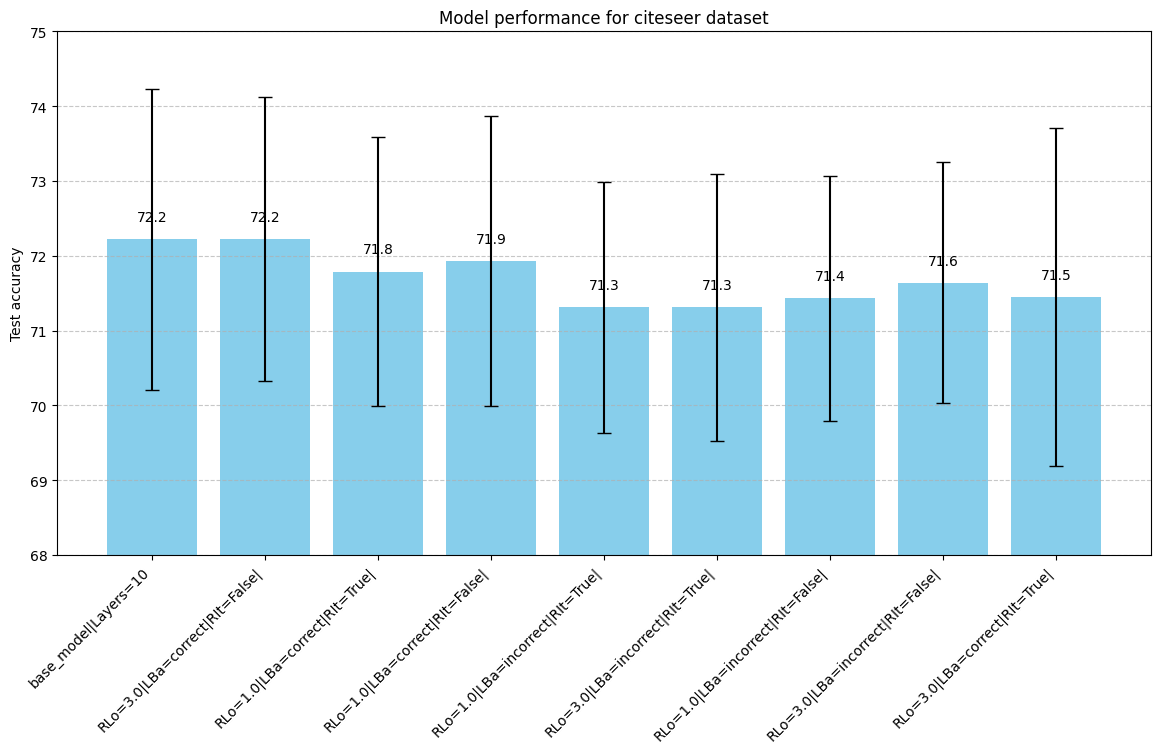

In [15]:
cols = ['transforms.R.loops', 'transforms.R.lower_bound_eq', 'model.backbone.num_layers', 'transforms.R.compute_every_it']

# iterate over rows
model_names = []
for index, row in agg_subset.iterrows():
    # Get values of the row
    values = [row[col].item() for col in cols]
    # Count "No Rewiring" values
    no_rewiring = values.count("No Rewiring")
    
    if no_rewiring == 3:
        model_name = f"base_model|Layers={row['model.backbone.num_layers'].item()}"
    else:
        model_name = ''
        for col, value in zip(cols, values):
            if col == 'transforms.R.loops':
                model_name += f"RLo={value}|"
            elif col == 'transforms.R.lower_bound_eq':
                model_name += f"LBa={value}|"
            elif col == 'model.backbone.num_layers':
                pass
                #model_name += f"NLa={value}|"
            elif col == 'transforms.R.compute_every_it':
                model_name += f"RIt={value}|"
            else:
                raise ValueError("Unknown column")
    model_names.append(model_name)
agg_subset['Model_name'] = model_names
 
# Plotting
plt.figure(figsize=(12, 6))
model_names = agg_subset['Model_name']
accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
accuracy_stds = np.array(agg_subset[('test/accuracy','std')])
bars = plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=5, color='skyblue')

accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
# Adding data labels on top of bars
for bar, mean in zip(bars, accuracy_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean:.1f}', ha='center', va='bottom')
#plt.xticks(rotation=45)
plt.title(f"Model performance for {dataset} dataset")
plt.ylabel("Test accuracy")
plt.tight_layout()
delta = np.array(agg_subset[('test/accuracy','std')]).max() + 1
plt.ylim((agg_subset[('test/accuracy','mean')].min()-delta).round(), (agg_subset[('test/accuracy','mean')].max()+delta).round())
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)

num_layers = agg_subset[agg_subset['Model_name'].apply(lambda x:  True if 'base_model' in x  else False)]['Model_name'].item().split('|')[1]
plt.savefig(f"figures/model_performance_{dataset}_num_layers={num_layers}.pdf")


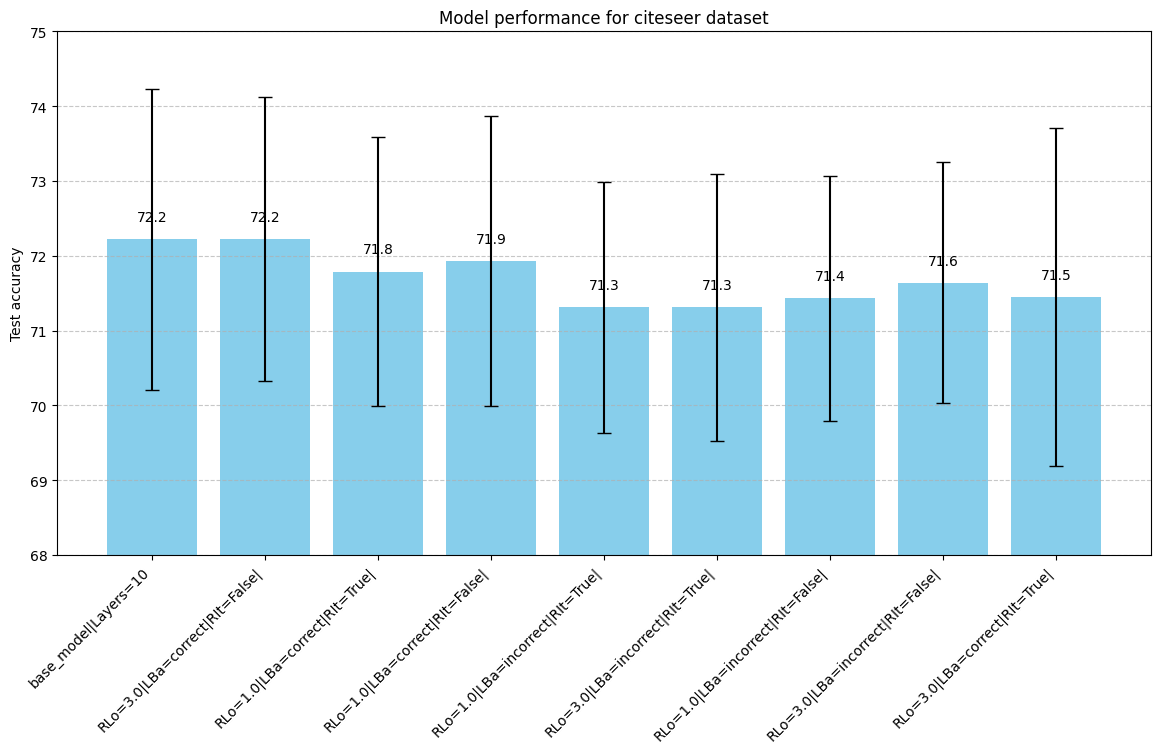

In [13]:
# keep only Model_name and test/accuracy columns
#agg_subset = agg_subset[['Model_name', 'test/accuracy']]
# Plotting
plt.figure(figsize=(12, 6))
model_names = agg_subset['Model_name']
accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
accuracy_stds = np.array(agg_subset[('test/accuracy','std')])
bars = plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=5, color='skyblue')

accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
# Adding data labels on top of bars
for bar, mean in zip(bars, accuracy_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean:.1f}', ha='center', va='bottom')
#plt.xticks(rotation=45)
plt.title(f"Model performance for {dataset} dataset")
plt.ylabel("Test accuracy")
plt.tight_layout()
delta = np.array(agg_subset[('test/accuracy','std')]).max() + 1
plt.ylim((agg_subset[('test/accuracy','mean')].min()-delta).round(), (agg_subset[('test/accuracy','mean')].max()+delta).round())
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)

num_layers = agg_subset[agg_subset['Model_name'].apply(lambda x:  True if 'base_model' in x  else False)]['Model_name'].item().split('|')[1]
plt.savefig(f"figures/model_performance_{dataset}_num_layers={num_layers}.png")

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'base_model|Layers=10'),
  Text(1, 0, 'RLo=3.0|LBa=correct|NLa=10|RIt=False|'),
  Text(2, 0, 'RLo=1.0|LBa=correct|NLa=10|RIt=True|'),
  Text(3, 0, 'RLo=1.0|LBa=correct|NLa=10|RIt=False|'),
  Text(4, 0, 'RLo=1.0|LBa=incorrect|NLa=10|RIt=True|'),
  Text(5, 0, 'RLo=3.0|LBa=incorrect|NLa=10|RIt=True|'),
  Text(6, 0, 'RLo=1.0|LBa=incorrect|NLa=10|RIt=False|'),
  Text(7, 0, 'RLo=3.0|LBa=incorrect|NLa=10|RIt=False|'),
  Text(8, 0, 'RLo=3.0|LBa=correct|NLa=10|RIt=True|')])

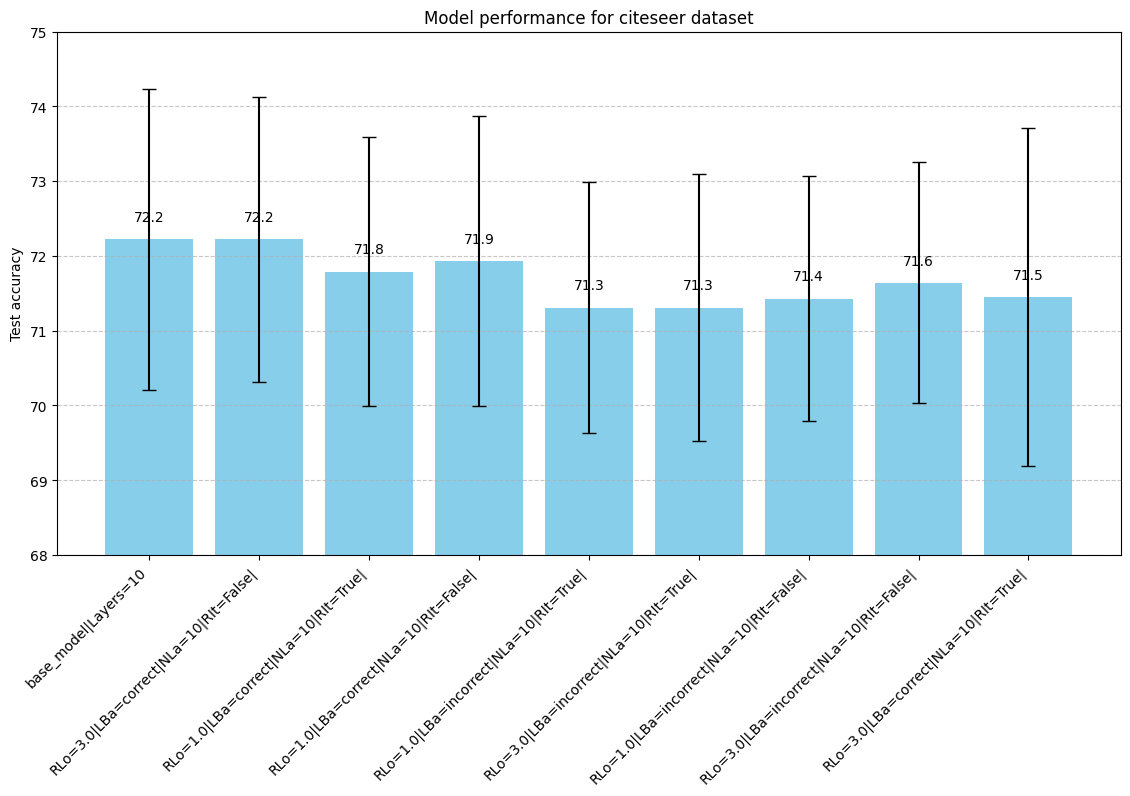

In [102]:
# Make the bar plot
# fig, ax = plt.subplots(figsize=(10, 5))
# #agg_subset.plot.bar(x='Model_name', y=('test/accuracy','mean'), ax=ax, legend=False)
# # plot ('test/accuracy','std') as error bars

# # a = np.array((agg_subset[('test/accuracy','mean')] - agg_subset[('test/accuracy','std')]))
# # b = np.array((agg_subset[('test/accuracy','mean')] + agg_subset[('test/accuracy','std')]))
# #yerr = [[i,j] for i,j in zip(a,b)]
# agg_subset = agg_subset.sort_values(by=('test/accuracy','mean'), ascending=False)
# bars = agg_subset.plot.bar(x='Model_name', y=('test/accuracy','mean'), yerr=np.array(agg_subset[('test/accuracy','std')]), ax=ax, legend=False)



# Plotting
plt.figure(figsize=(12, 6))
model_names = agg_subset['Model_name']
accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
accuracy_stds = np.array(agg_subset[('test/accuracy','std')])
bars = plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=5, color='skyblue')

accuracy_means = np.array(agg_subset[('test/accuracy','mean')])
# Adding data labels on top of bars
for bar, mean in zip(bars, accuracy_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean:.1f}', ha='center', va='bottom')
#plt.xticks(rotation=45)
plt.title(f"Model performance for {dataset} dataset")
plt.ylabel("Test accuracy")
plt.tight_layout()
delta = np.array(agg_subset[('test/accuracy','std')]).max() + 1
plt.ylim((agg_subset[('test/accuracy','mean')].min()-delta).round(), (agg_subset[('test/accuracy','mean')].max()+delta).round())
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)

num_layers = agg_subset[agg_subset['Model_name'].apply(lambda x:  True if 'base_model' in x  else False)]['Model_name'].item().split('|')[1]
plt.savefig(f"figures/model_performance_{dataset}_num_layers={num_layers}.png")
#plt.show()


'Layers=10'

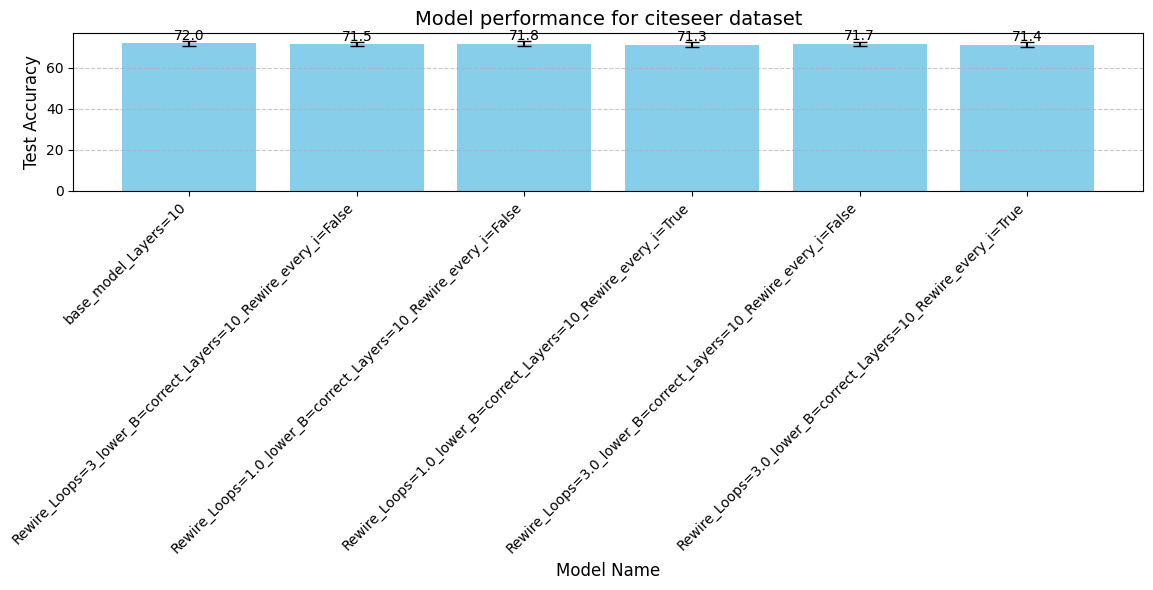

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
model_names = ["base_model_Layers=10", "Rewire_Loops=3_lower_B=correct_Layers=10_Rewire_every_i=False",
               "Rewire_Loops=1.0_lower_B=correct_Layers=10_Rewire_every_i=False", 
               "Rewire_Loops=1.0_lower_B=correct_Layers=10_Rewire_every_i=True", 
               "Rewire_Loops=3.0_lower_B=correct_Layers=10_Rewire_every_i=False", 
               "Rewire_Loops=3.0_lower_B=correct_Layers=10_Rewire_every_i=True"]
accuracy_means = [72, 71.5, 71.8, 71.3, 71.7, 71.4]
accuracy_stds = [1.2, 1.0, 1.1, 1.3, 1.0, 1.2]

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_means, yerr=accuracy_stds, capsize=5, color='skyblue')

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adding titles and labels
plt.title('Model performance for citeseer dataset', fontsize=14)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)

# Adding data labels on top of bars
for bar, mean in zip(bars, accuracy_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{mean:.1f}', ha='center', va='bottom')

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


array([[70.21, 74.23],
       [70.32, 74.12],
       [69.99, 73.59],
       [69.99, 73.87],
       [69.63, 72.99],
       [69.53, 73.09],
       [69.79, 73.07],
       [70.03, 73.25],
       [69.19, 73.71]])

   a    b
0  1  0.5
1  1  0.5
2  2  2.0
3  3  3.0
4  3  4.0


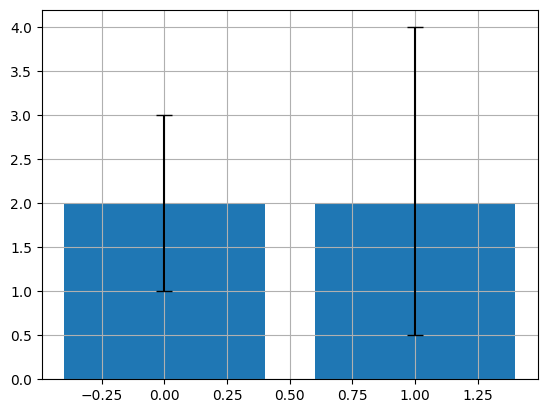

In [69]:
df = pd.DataFrame()
df['a'] = [1, 1, 2, 3, 3]
df['b'] = [0.5, 0.5, 2, 3, 4]
print(df)

plt.bar(np.arange(df.shape[1]), df.mean(), yerr=[df.mean()-df.min(), df.max()-df.mean()], capsize=6)
plt.grid()

plt.show()

In [70]:
[df.mean()-df.min(), df.max()-df.mean()]

[a    1.0
 b    1.5
 dtype: float64,
 a    1.0
 b    2.0
 dtype: float64]

[[(26, 70.21), (26, 74.23)],
 [(16, 70.32), (16, 74.12)],
 [(5, 69.99000000000001), (5, 73.59)],
 [(4, 69.99000000000001), (4, 73.87)],
 [(11, 69.63), (11, 72.99000000000001)],
 [(23, 69.53), (23, 73.09)],
 [(10, 69.79), (10, 73.07000000000001)],
 [(22, 70.03), (22, 73.25)],
 [(17, 69.19), (17, 73.71000000000001)]]

In [51]:
(agg_subset[('test/accuracy','mean')] + agg_subset[('test/accuracy','std')]).items())

SyntaxError: unmatched ')' (4182129900.py, line 1)

[[70.21, 74.23],
 [70.32, 74.12],
 [69.99, 73.59],
 [69.99, 73.87],
 [69.63, 72.99],
 [69.53, 73.09],
 [69.79, 73.07],
 [70.03, 73.25],
 [69.19, 73.71]]

66.0

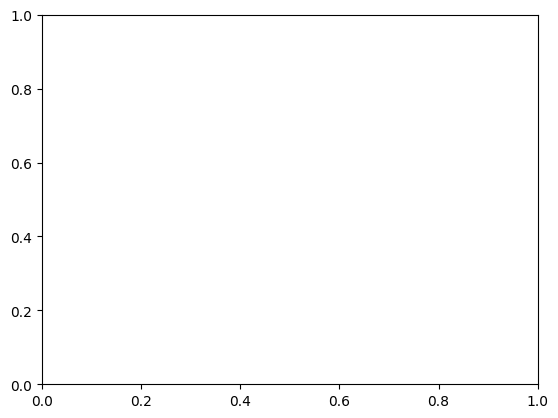

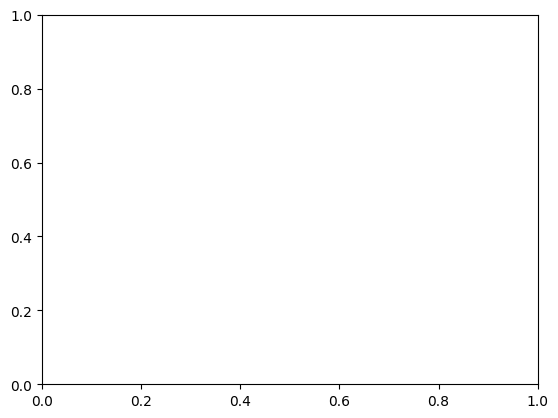

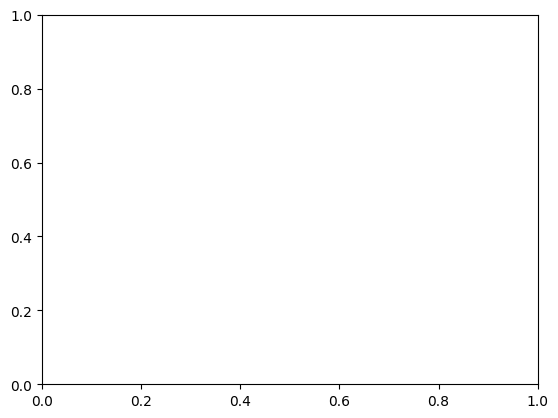

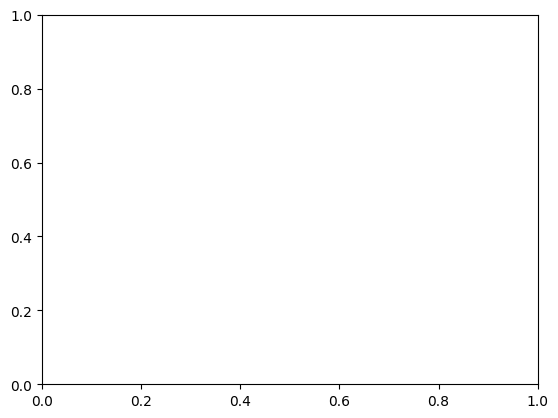

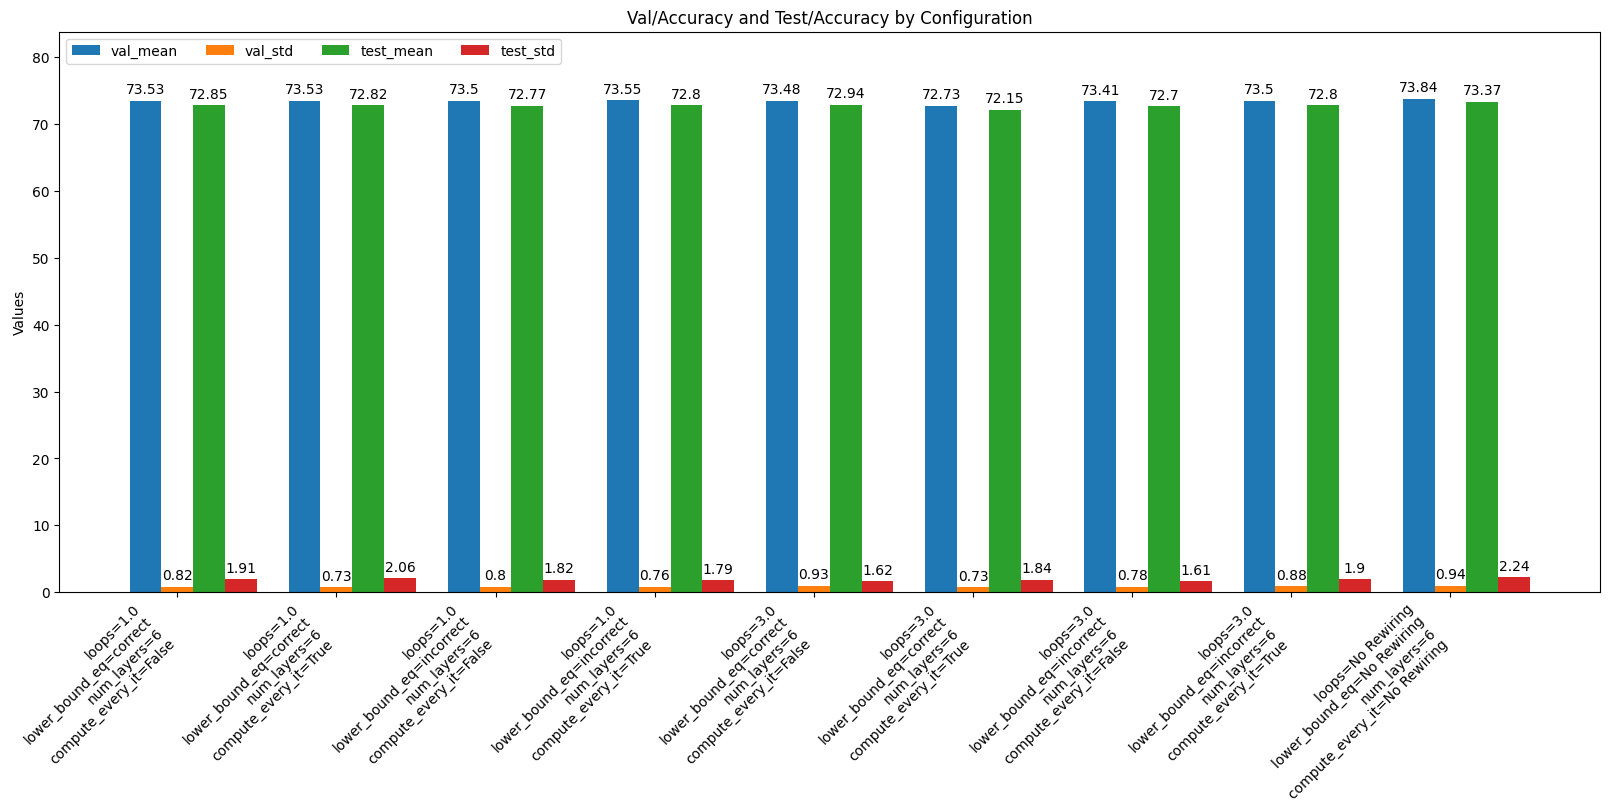

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from your table
rows = [
    {"loops": 1.0, "lower_bound_eq": "correct", "num_layers": 6, "compute_every_it": False, "val_mean": 73.53, "val_std": 0.82, "test_mean": 72.85, "test_std": 1.91},
    {"loops": 1.0, "lower_bound_eq": "correct", "num_layers": 6, "compute_every_it": True, "val_mean": 73.53, "val_std": 0.73, "test_mean": 72.82, "test_std": 2.06},
    {"loops": 1.0, "lower_bound_eq": "incorrect", "num_layers": 6, "compute_every_it": False, "val_mean": 73.50, "val_std": 0.80, "test_mean": 72.77, "test_std": 1.82},
    {"loops": 1.0, "lower_bound_eq": "incorrect", "num_layers": 6, "compute_every_it": True, "val_mean": 73.55, "val_std": 0.76, "test_mean": 72.80, "test_std": 1.79},
    {"loops": 3.0, "lower_bound_eq": "correct", "num_layers": 6, "compute_every_it": False, "val_mean": 73.48, "val_std": 0.93, "test_mean": 72.94, "test_std": 1.62},
    {"loops": 3.0, "lower_bound_eq": "correct", "num_layers": 6, "compute_every_it": True, "val_mean": 72.73, "val_std": 0.73, "test_mean": 72.15, "test_std": 1.84},
    {"loops": 3.0, "lower_bound_eq": "incorrect", "num_layers": 6, "compute_every_it": False, "val_mean": 73.41, "val_std": 0.78, "test_mean": 72.70, "test_std": 1.61},
    {"loops": 3.0, "lower_bound_eq": "incorrect", "num_layers": 6, "compute_every_it": True, "val_mean": 73.50, "val_std": 0.88, "test_mean": 72.80, "test_std": 1.90},
    {"loops": "No Rewiring", "lower_bound_eq": "No Rewiring", "num_layers": 6, "compute_every_it": "No Rewiring", "val_mean": 73.84, "val_std": 0.94, "test_mean": 73.37, "test_std": 2.24},
]

# Creating labels for x-axis from the table columns
x_labels = [
    f"loops={row['loops']}\nlower_bound_eq={row['lower_bound_eq']}\nnum_layers={row['num_layers']}\ncompute_every_it={row['compute_every_it']}" 
    for row in rows
]

x = np.arange(len(rows))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(16, 8))

# Create the bar plot
for key in ["val_mean", "val_std", "test_mean", "test_std"]:
    measurements = [row[key] for row in rows]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurements, width, label=key)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Val/Accuracy and Test/Accuracy by Configuration')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper left', ncol=4)
ax.set_ylim(0, max(max(row[key] for key in ["val_mean", "val_std", "test_mean", "test_std"]) for row in rows) + 10)

plt.xticks(rotation=45, ha='right')
plt.show()


,transforms.R.loops,transforms.R.lower_bound_eq,model.backbone.num_layers,transforms.R.compute_every_it
,,,,
0,1.0,correct,6,False
1,1.0,correct,6,True
6,1.0,incorrect,6,False
7,1.0,incorrect,6,True
12,3.0,correct,6,False
13,3.0,correct,6,True
18,3.0,incorrect,6,False
19,3.0,incorrect,6,True
24,No Rewiring,No Rewiring,6,No Rewiring


In [51]:
agg_subset[('val/accuracy','mean')]

0     73.53
1     73.53
6     73.50
7     73.55
12    73.48
13    72.73
18    73.41
19    73.50
24    73.84
Name: (val/accuracy, mean), dtype: float64

0      6
1      6
6      6
7      6
12     6
13     6
18     6
19     6
24     6
2      8
3      8
8      8
9      8
14     8
15     8
20     8
21     8
25     8
4     10
5     10
10    10
11    10
16    10
17    10
22    10
23    10
26    10
Name: model.backbone.num_layers, dtype: int64

In [39]:
levels = [
    ['model.backbone.num_layers', 'transforms.R.loops', 'transforms.R.lower_bound_eq', 'transforms.R.compute_every_it'],
    ['val/accuracy', 'val/accuracy', 'test/accuracy', 'test/accuracy', 'val/auroc', 'val/auroc', 'test/auroc', 'test/auroc', 'val/recall', 'val/recall', 'test/recall', 'test/recall', 'val/precision', 'val/precision', 'test/precision', 'test/precision']
]

codes = [
    [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
]

multi_index = pd.MultiIndex(levels=levels, codes=codes)
            # (    'model.backbone.num_layers',     ''),
            # (           'transforms.R.loops',     ''),
            # (  'transforms.R.lower_bound_eq',     ''),
            # ('transforms.R.compute_every_it',     ''),
            # (                 'val/accuracy', 'mean'),
            # (                 'val/accuracy',  'std'),
            # (                'test/accuracy', 'mean'),
            # (                'test/accuracy',  'std'),
            # (                    'val/auroc', 'mean'),
            # (                    'val/auroc',  'std'),
            # (                   'test/auroc', 'mean'),
            # (                   'test/auroc',  'std'),
            # (                   'val/recall', 'mean'),
            # (                   'val/recall',  'std'),
            # (                  'test/recall', 'mean'),
            # (                  'test/recall',  'std'),
            # (                'val/precision', 'mean'),
            # (                'val/precision',  'std'),
            # (               'test/precision', 'mean'),
            # (               'test/precision',  'std')])

ValueError: Level values must be unique: ['val/accuracy', 'val/accuracy', 'test/accuracy', 'test/accuracy', 'val/auroc', 'val/auroc', 'test/auroc', 'test/auroc', 'val/recall', 'val/recall', 'test/recall', 'test/recall', 'val/precision', 'val/precision', 'test/precision', 'test/precision'] on level 1

In [31]:
aggregated.columns

MultiIndex([(           'transforms.R.loops',     ''),
            (  'transforms.R.lower_bound_eq',     ''),
            (    'model.backbone.num_layers',     ''),
            ('transforms.R.compute_every_it',     ''),
            (                 'val/accuracy', 'mean'),
            (                 'val/accuracy',  'std'),
            (                'test/accuracy', 'mean'),
            (                'test/accuracy',  'std'),
            (                    'val/auroc', 'mean'),
            (                    'val/auroc',  'std'),
            (                   'test/auroc', 'mean'),
            (                   'test/auroc',  'std'),
            (                   'val/recall', 'mean'),
            (                   'val/recall',  'std'),
            (                  'test/recall', 'mean'),
            (                  'test/recall',  'std'),
            (                'val/precision', 'mean'),
            (                'val/precision',  'std'),
          

In [ ]:
df.groupby(sweeped_columns, dropna=False).agg({col: ["mean", "std"] for col in performance_columns})